# ECE 570 Assignment 6 Exercise






Your Name: Nikita Ravi

In [1]:
import torchvision
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

## Exercise 1: Creating an image denoiser using a CNN autoencoder. (30 points)
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In this task, we concatenate the original dataset and noisy dataset and get a single dataloader. You should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1). 

In [3]:
class AddGaussianNoise(object):
  ###########################   <YOUR CODE>  ############################
  def __init__(self, mean, std):
    self.mean, self.std = mean, std

  def __call__(self, tensor):
    noise = tensor + torch.randn(tensor.size()) * self.std + self.mean
    return torch.clamp(noise, min=0, max=1)
  




  #########################  <END YOUR CODE>  ############################


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

1.0
0.0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<ipython-input-4-6033c5b6a32e>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


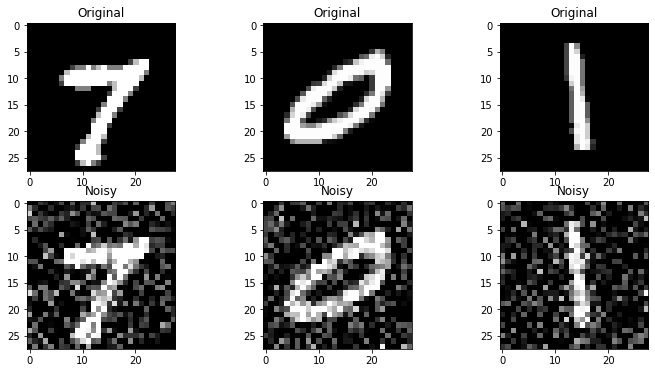

In [4]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 
batch_idx, (noisy, original) = next(enumerate(train_loader))
fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(original[idx][0], cmap='gray')
  ax[0,idx].set_title('Original')
  ax[1,idx].imshow(noisy[idx][0], cmap='gray')
  ax[1,idx].set_title('Noisy')


fig.show()




#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

In [5]:
###########################   <YOUR CODE>  ############################
latent_feature = 4
class autoencoder(nn.Module):
  def __init__(self):
    super(autoencoder, self).__init__()

    # Encoders
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=latent_feature, kernel_size=3, padding=1)
    self.pooling = nn.MaxPool2d(2,2)
    # Decoders
    self.transConv1 = nn.ConvTranspose2d(in_channels=latent_feature, out_channels=16, kernel_size=2, stride=2)
    self.transConv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2)

  def forward(self, x):
    x = F.relu(self.conv1(x))  
    x = self.pooling(x) 
    x = F.relu(self.conv2(x))  
    x = self.pooling(x) 
    x = F.relu(self.transConv1(x)) 
    x = torch.sigmoid(self.transConv2(x)) 
    return x
    
#########################  <END YOUR CODE>  ############################

In [6]:
def train(epoch, classifier, train_loader, criterion, optimizer, device):
  classifier.train()

  for batch_idx, (noisy, original) in enumerate(train_loader):
    noisy, original = noisy.to(device), original.to(device)
    optimizer.zero_grad()
    output = classifier(noisy)
    loss = criterion(output, original)
    loss.backward()
    optimizer.step()

    if(not batch_idx % 10): 
      train_losses.append(loss.item()/batch_size_train) 
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if(not batch_idx % 100): 
      print(f'Epoch {epoch}: [{batch_idx*len(original)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')

def test(epoch, classifier, test_loader, criterion, optimizer, device):
  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for noisy, original in test_loader:
      noisy, original = noisy.to(device), original.to(device)
      output = classifier(noisy)
      test_loss += criterion(output, original).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

In [7]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 7
classifier = autoencoder()
classifier = classifier.to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
criterion = nn.MSELoss(reduction='sum')

for epoch in range(1, max_epoch+1):
  print("training: ")
  train(epoch, classifier, train_loader, criterion, optimizer, device)
  print("testing: ")
  test(epoch, classifier, test_loader, criterion, optimizer, device)

training: 
Epoch 1: [0/60000] Loss: 230.8500518798828
Epoch 1: [6400/60000] Loss: 222.07559204101562
Epoch 1: [12800/60000] Loss: 207.06793212890625
Epoch 1: [19200/60000] Loss: 179.4084014892578
Epoch 1: [25600/60000] Loss: 143.7228546142578
Epoch 1: [32000/60000] Loss: 117.76242065429688
Epoch 1: [38400/60000] Loss: 101.91992950439453
Epoch 1: [44800/60000] Loss: 96.4582748413086
Epoch 1: [51200/60000] Loss: 91.23274230957031
Epoch 1: [57600/60000] Loss: 87.54364013671875
testing: 
Test result on epoch 1: Avg loss is 88.724484375
training: 
Epoch 2: [0/60000] Loss: 86.91552734375
Epoch 2: [6400/60000] Loss: 81.37911987304688
Epoch 2: [12800/60000] Loss: 80.39851379394531
Epoch 2: [19200/60000] Loss: 76.33672332763672
Epoch 2: [25600/60000] Loss: 75.1395263671875
Epoch 2: [32000/60000] Loss: 67.56411743164062
Epoch 2: [38400/60000] Loss: 69.82588195800781
Epoch 2: [44800/60000] Loss: 62.24470901489258
Epoch 2: [51200/60000] Loss: 59.70317840576172
Epoch 2: [57600/60000] Loss: 53.71949

<ipython-input-8-9c994dee0b9d>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


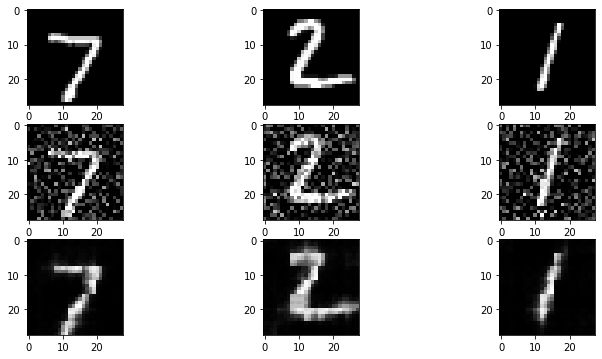

In [8]:
batch_idx, (noisy, original) = next(enumerate(test_loader))
noisy,original = noisy.to(device),original.to(device)
output = classifier(noisy).cpu().detach()
noisy = noisy.cpu()
original = original.cpu()

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(original[idx][0], cmap='gray')
  ax[1,idx].imshow(noisy[idx][0], cmap='gray')
  ax[2,idx].imshow(output[idx][0], cmap='gray')

fig.show()

## Exercise 2: Build a variational autoencoder(VAE) that can generate MNIST images (70 points)

### Task 0: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [9]:

###########################   <YOUR CODE>  ############################
train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)
batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

#########################  <END YOUR CODE>  ############################

### Task 1: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build the VAE (variational autoencoder) model satisfying following conditions which simplifies the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance along each dimension.
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.

While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With such assumpition, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$. 


Your task here is to write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the the reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [10]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  ###########################   <YOUR CODE>  ############################
  ReconstructionLoss = nn.BCELoss(reduction="sum")
  reconLoss = ReconstructionLoss(output, images)
  KL = -0.5 * torch.sum(1 + log_var - torch.pow(mu,2) - torch.exp(log_var))  

  return reconLoss, KL

  #########################  <END YOUR CODE>  ############################


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [11]:
import torch.nn as nn
import torch.nn.functional as F


class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    ###########################   <YOUR CODE>  ############################
    # define the transformations for your encoder and decoder
    ## encoder
    self.fc1 = nn.Linear(in_features=28*28, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=latent_feature*2)

    ## decoder
    self.fc3 = nn.Linear(in_features=latent_feature, out_features=512)
    self.fc4 = nn.Linear(in_features=512, out_features=28*28)


    #########################  <END YOUR CODE>  ############################

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """
    ###########################   <YOUR CODE>  ############################
    std = torch.exp(0.5 * log_var)
    epsilon = torch.rand_like(std)
    sample = mu + std*epsilon

    #########################  <END YOUR CODE>  ############################
    return sample
  def encoder(self, x):
    """
    :param x: input distribution

    You should first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """
    ###########################   <YOUR CODE>  ############################
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.fc2(x).view(-1,2,self.latent_feature)
    mu = x[:,0,:]
    log_var = x[:,1,:]
    z = self.reparameterize(mu, log_var)
    #########################  <END YOUR CODE>  ###########################

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    ###########################   <YOUR CODE>  ############################
    x = F.relu(self.fc3(z))
    x = torch.sigmoid(self.fc4(x))
    x = x.view(-1, 1, 28, 28)

    #########################  <END YOUR CODE>  ###########################
    return x


  
  def forward(self, x):
    """
    :param x: input variables

    You should compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

    ###########################   <YOUR CODE>  ############################
    mu, log_var, z = self.encoder(x)
    x = self.decoder(z)

    #########################  <END YOUR CODE>  ###########################

    
    return x, mu, log_var

### Task 3: Train and visualize output
1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

In [12]:
###########################   <YOUR CODE>  ############################
def train(epoch, classifier, train_loader, criterion, optimizer, device):
  classifier.train()

  for batch_idx, (images, _) in enumerate(train_loader):
    images = images.to(device)
    optimizer.zero_grad()
    output, mu, log_var = classifier(images)
    reconLoss, KL = vae_loss(output, mu, log_var, images)
    loss = reconLoss + KL
    loss.backward()
    optimizer.step()

    if(not batch_idx % 10): 
      train_losses.append(loss.item()/batch_size_train) 
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      Reconstruction_loss.append(reconLoss.item() / batch_size_train)
      KL_loss.append(KL.item() / batch_size_train)
    if(not batch_idx % 100): 
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')

def test(epoch, classifier, test_loader, criterion, optimizer, device):
  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.to(device)
      output, mu, log_var = classifier(images)
      reconLoss, KL = criterion(output, mu, log_var, images)
      loss = (reconLoss + KL).item()
      test_loss += loss
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

#########################  <END YOUR CODE>  ###########################


In [13]:
def plot_loss(batch, ELBO_loss, Reconstruction_loss, KL_loss):
  plt.plot(batch, ELBO_loss, color='r', label="ELBO loss")
  plt.plot(batch, Reconstruction_loss, color='b', label="reconstruction loss")
  plt.plot(batch, KL_loss, color='g', label="KL loss")
  plt.legend()
  plt.show()

In [14]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 3
classifier = our_VAE()
classifier = classifier.to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
Reconstruction_loss, KL_loss = [], []

for epoch in range(1, max_epoch+1):
  print("training: ")
  train(epoch, classifier, train_loader, vae_loss, optimizer, device)
  print("testing: ")
  test(epoch, classifier, test_loader, vae_loss, optimizer, device)

training: 
Epoch 1: [0/60000] Loss: 545.7872314453125
Epoch 1: [6400/60000] Loss: 244.9322509765625
Epoch 1: [12800/60000] Loss: 220.5683135986328
Epoch 1: [19200/60000] Loss: 200.74322509765625
Epoch 1: [25600/60000] Loss: 180.40966796875
Epoch 1: [32000/60000] Loss: 160.23422241210938
Epoch 1: [38400/60000] Loss: 159.83848571777344
Epoch 1: [44800/60000] Loss: 150.27914428710938
Epoch 1: [51200/60000] Loss: 140.37753295898438
Epoch 1: [57600/60000] Loss: 133.6109619140625
testing: 
Test result on epoch 1: Avg loss is 133.348840625
training: 
Epoch 2: [0/60000] Loss: 132.4317626953125
Epoch 2: [6400/60000] Loss: 127.14097595214844
Epoch 2: [12800/60000] Loss: 130.45095825195312
Epoch 2: [19200/60000] Loss: 131.5988006591797
Epoch 2: [25600/60000] Loss: 127.97630310058594
Epoch 2: [32000/60000] Loss: 125.37033081054688
Epoch 2: [38400/60000] Loss: 116.73977661132812
Epoch 2: [44800/60000] Loss: 113.379638671875
Epoch 2: [51200/60000] Loss: 121.02595520019531
Epoch 2: [57600/60000] Loss

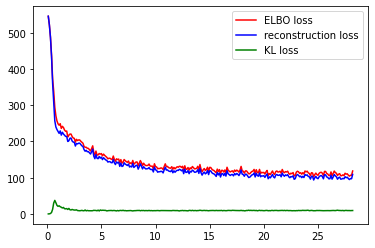

In [15]:
batch = np.linspace(1, len(Reconstruction_loss) , num=len(Reconstruction_loss), retstep=10)
batch = [i/10 for i in list(batch[0])]
plot_loss(batch, train_losses, Reconstruction_loss, KL_loss)

<ipython-input-16-78b26b1614cc>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


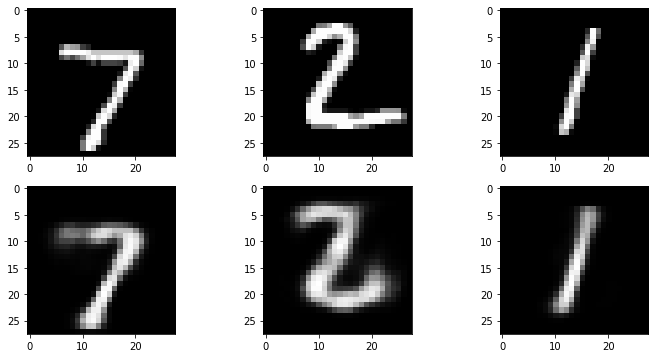

In [16]:
batch_idx, (original, _) = next(enumerate(test_loader))
original = original.to(device)
output, mean, log_var = classifier(original)
output = output.cpu().detach()
original = original.cpu()

fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(original[idx][0], cmap='gray')
  ax[1,idx].imshow(output[idx][0], cmap='gray')

fig.show()

### Task 4.1: Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training with the given function ``plot_latent``.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after **each** epoch. You should use the **test** data for plotting this visualization task.


In [17]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      _,_,z = vae.encoder(images)
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

training: 
Epoch 1: [0/60000] Loss: 549.9835205078125
Epoch 1: [6400/60000] Loss: 226.09530639648438
Epoch 1: [12800/60000] Loss: 215.445556640625
Epoch 1: [19200/60000] Loss: 200.44972229003906
Epoch 1: [25600/60000] Loss: 203.13607788085938
Epoch 1: [32000/60000] Loss: 196.43536376953125
Epoch 1: [38400/60000] Loss: 181.90411376953125
Epoch 1: [44800/60000] Loss: 184.2556610107422
Epoch 1: [51200/60000] Loss: 186.52772521972656
Epoch 1: [57600/60000] Loss: 188.19931030273438
testing: 
Test result on epoch 1: Avg loss is 182.285075


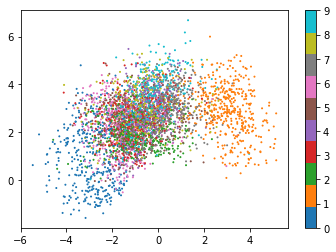

training: 
Epoch 2: [0/60000] Loss: 180.23060607910156
Epoch 2: [6400/60000] Loss: 187.30630493164062
Epoch 2: [12800/60000] Loss: 193.06411743164062
Epoch 2: [19200/60000] Loss: 168.2838897705078
Epoch 2: [25600/60000] Loss: 184.73207092285156
Epoch 2: [32000/60000] Loss: 175.71751403808594
Epoch 2: [38400/60000] Loss: 179.2344207763672
Epoch 2: [44800/60000] Loss: 159.04849243164062
Epoch 2: [51200/60000] Loss: 179.23304748535156
Epoch 2: [57600/60000] Loss: 172.74705505371094
testing: 
Test result on epoch 2: Avg loss is 173.95056875


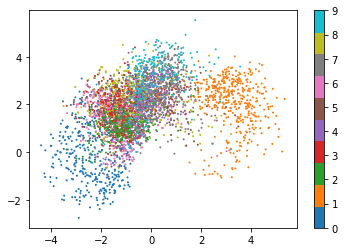

training: 
Epoch 3: [0/60000] Loss: 181.2763671875
Epoch 3: [6400/60000] Loss: 179.87718200683594
Epoch 3: [12800/60000] Loss: 154.8586883544922
Epoch 3: [19200/60000] Loss: 173.3944854736328
Epoch 3: [25600/60000] Loss: 167.69345092773438
Epoch 3: [32000/60000] Loss: 164.35638427734375
Epoch 3: [38400/60000] Loss: 170.56210327148438
Epoch 3: [44800/60000] Loss: 167.31011962890625
Epoch 3: [51200/60000] Loss: 174.2105712890625
Epoch 3: [57600/60000] Loss: 170.24502563476562
testing: 
Test result on epoch 3: Avg loss is 168.92071875


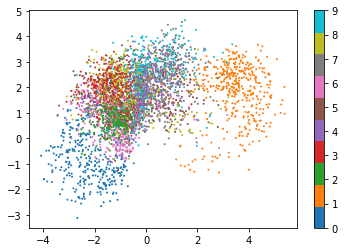

training: 
Epoch 4: [0/60000] Loss: 167.67762756347656
Epoch 4: [6400/60000] Loss: 161.89810180664062
Epoch 4: [12800/60000] Loss: 176.0834197998047
Epoch 4: [19200/60000] Loss: 158.9931182861328
Epoch 4: [25600/60000] Loss: 164.5732879638672
Epoch 4: [32000/60000] Loss: 156.8340301513672
Epoch 4: [38400/60000] Loss: 161.6139373779297
Epoch 4: [44800/60000] Loss: 152.3040771484375
Epoch 4: [51200/60000] Loss: 171.1837158203125
Epoch 4: [57600/60000] Loss: 163.99134826660156
testing: 
Test result on epoch 4: Avg loss is 165.344953125


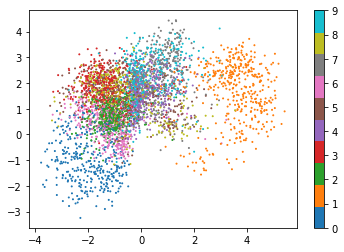

training: 
Epoch 5: [0/60000] Loss: 164.2576904296875
Epoch 5: [6400/60000] Loss: 177.6613006591797
Epoch 5: [12800/60000] Loss: 162.7783660888672
Epoch 5: [19200/60000] Loss: 159.45335388183594
Epoch 5: [25600/60000] Loss: 165.34649658203125
Epoch 5: [32000/60000] Loss: 164.7527313232422
Epoch 5: [38400/60000] Loss: 165.85057067871094
Epoch 5: [44800/60000] Loss: 182.10873413085938
Epoch 5: [51200/60000] Loss: 159.3990478515625
Epoch 5: [57600/60000] Loss: 166.54644775390625
testing: 
Test result on epoch 5: Avg loss is 163.1277703125


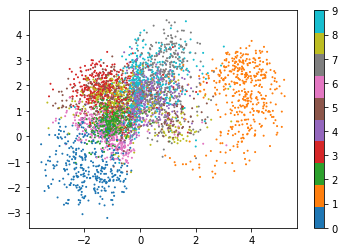

training: 
Epoch 6: [0/60000] Loss: 169.48304748535156
Epoch 6: [6400/60000] Loss: 159.82144165039062
Epoch 6: [12800/60000] Loss: 169.7771759033203
Epoch 6: [19200/60000] Loss: 158.8091583251953
Epoch 6: [25600/60000] Loss: 164.63194274902344
Epoch 6: [32000/60000] Loss: 159.52012634277344
Epoch 6: [38400/60000] Loss: 166.5579071044922
Epoch 6: [44800/60000] Loss: 157.20968627929688
Epoch 6: [51200/60000] Loss: 164.24908447265625
Epoch 6: [57600/60000] Loss: 159.01295471191406
testing: 
Test result on epoch 6: Avg loss is 161.94974375


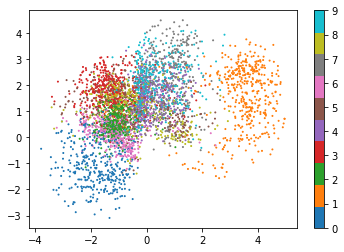

training: 
Epoch 7: [0/60000] Loss: 152.37814331054688
Epoch 7: [6400/60000] Loss: 164.418701171875
Epoch 7: [12800/60000] Loss: 141.70668029785156
Epoch 7: [19200/60000] Loss: 160.63197326660156
Epoch 7: [25600/60000] Loss: 154.4950408935547
Epoch 7: [32000/60000] Loss: 160.77081298828125
Epoch 7: [38400/60000] Loss: 167.8980255126953
Epoch 7: [44800/60000] Loss: 165.49276733398438
Epoch 7: [51200/60000] Loss: 155.91725158691406
Epoch 7: [57600/60000] Loss: 162.3254852294922
testing: 
Test result on epoch 7: Avg loss is 160.969271875


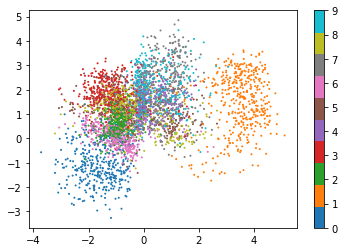

training: 
Epoch 8: [0/60000] Loss: 172.5723876953125
Epoch 8: [6400/60000] Loss: 164.40777587890625
Epoch 8: [12800/60000] Loss: 161.35321044921875
Epoch 8: [19200/60000] Loss: 163.18386840820312
Epoch 8: [25600/60000] Loss: 152.4736328125
Epoch 8: [32000/60000] Loss: 159.60955810546875
Epoch 8: [38400/60000] Loss: 160.4086151123047
Epoch 8: [44800/60000] Loss: 161.20481872558594
Epoch 8: [51200/60000] Loss: 157.85093688964844
Epoch 8: [57600/60000] Loss: 161.43540954589844
testing: 
Test result on epoch 8: Avg loss is 160.1131640625


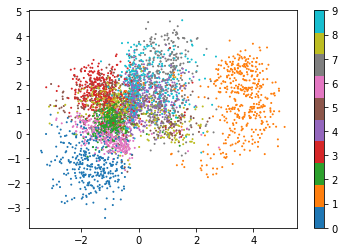

training: 
Epoch 9: [0/60000] Loss: 153.14686584472656
Epoch 9: [6400/60000] Loss: 155.12232971191406
Epoch 9: [12800/60000] Loss: 170.95301818847656
Epoch 9: [19200/60000] Loss: 161.60357666015625
Epoch 9: [25600/60000] Loss: 148.90090942382812
Epoch 9: [32000/60000] Loss: 164.33172607421875
Epoch 9: [38400/60000] Loss: 159.8367462158203
Epoch 9: [44800/60000] Loss: 146.8607940673828
Epoch 9: [51200/60000] Loss: 159.27047729492188
Epoch 9: [57600/60000] Loss: 158.22406005859375
testing: 
Test result on epoch 9: Avg loss is 159.401275


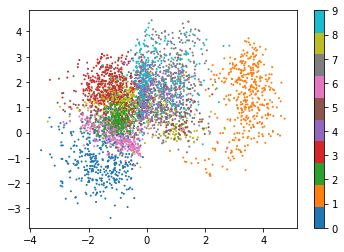

training: 
Epoch 10: [0/60000] Loss: 159.3289794921875
Epoch 10: [6400/60000] Loss: 159.3866424560547
Epoch 10: [12800/60000] Loss: 163.51658630371094
Epoch 10: [19200/60000] Loss: 160.18844604492188
Epoch 10: [25600/60000] Loss: 156.5498809814453
Epoch 10: [32000/60000] Loss: 157.03543090820312
Epoch 10: [38400/60000] Loss: 151.465087890625
Epoch 10: [44800/60000] Loss: 164.54156494140625
Epoch 10: [51200/60000] Loss: 162.85702514648438
Epoch 10: [57600/60000] Loss: 152.00296020507812
testing: 
Test result on epoch 10: Avg loss is 158.7824375


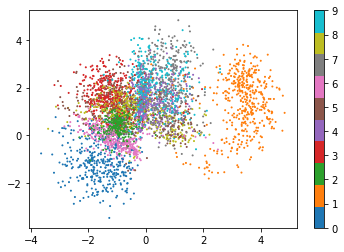

In [18]:
###########################   <YOUR CODE>  ############################
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 10
classifier = our_VAE(latent_feature=2)
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

# plot_latent(classifier, train_loader)

for epoch in range(1, max_epoch+1):
  classifier = classifier.to(device)
  print("training: ")
  train(epoch, classifier, train_loader, vae_loss, optimizer, device)
  print("testing: ")
  test(epoch, classifier, test_loader, vae_loss, optimizer, device)
  classifier = classifier.cpu()
  plot_latent(classifier, test_loader)
#########################  <END YOUR CODE>  ###########################

### Task 4.2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space. 
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels).
1. With a trained model and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. **Plot** all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. **Plot** all $x'$ images you get in a 1x11 grid.

<ipython-input-19-310de8a1dd32>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


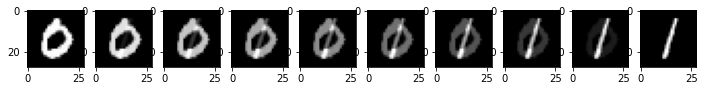

In [19]:
###########################   <YOUR CODE>  ############################
batch_idx, (images, labels) = next(enumerate(test_loader))
input_images_0 = images[labels == 0][0]
input_images_1 = images[labels == 1][0]
mu, log_var, z_0 = classifier.encoder(input_images_0)
mu, log_var, z_1 = classifier.encoder(input_images_1)

fig, ax = plt.subplots(1,10)
fig.set_size_inches(12,6)

alpha = torch.linspace(0, 1, 10)
for idx in range(0, len(alpha)):
  x_prime = torch.mul(input_images_1, alpha[idx]) + torch.mul(input_images_0, (1 - alpha[idx]))
  ax[idx].imshow(x_prime[0], cmap="gray")

fig.show()
#########################  <END YOUR CODE>  ###########################

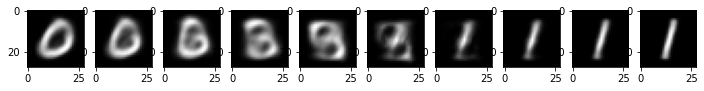

In [49]:
fig, ax = plt.subplots(1,10)
fig.set_size_inches(12,6)

alpha = torch.linspace(0, 1, 10)
for idx in range(0, len(alpha)):
  z_prime = torch.mul(z_1, alpha[idx]) + torch.mul(z_0, (1 - alpha[idx]))
  x_prime = classifier.decoder(z_prime)
  ax[idx].imshow(x_prime.detach().squeeze(), cmap="gray")